# Non-linear regression with PyTorch and neural networks

In this tutorial, we will explore coding neural networks to do a non-linear regression with a multi-layer perceptron.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

## Generate mock data

In this exercise, we generate 100 pairs of values from a non-linear function 

$$f(x) = x^3 - x^2 + 25 \cdot \sin(2x),$$

and we add noise to a random uniform sample:

$$ y = \mathcal{N}(f(x), 10)$$

Text(0, 0.5, 'y')

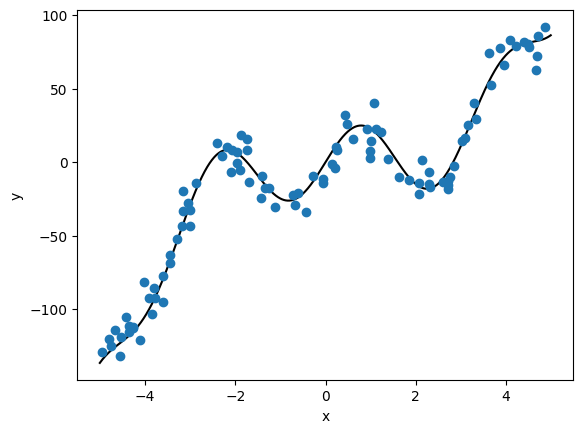

In [2]:
np.random.seed(42)

def ftrue(x):
    """ True data function """
    return(x ** 3 - x ** 2 + 25 * np.sin(2 * x))

xtrue = np.arange(-5, 5, 0.01)
ytrue = ftrue(xtrue)

n = 100
x = np.random.uniform(-5, 5, n)
y = ftrue(x) + np.random.normal(0, 10, n)

plt.plot(xtrue, ytrue, color='k')
plt.plot(x, y, 'o', color='C0')
plt.xlabel('x')
plt.ylabel('y')

## MLP in PyTorch

In this section, we code a simple network using PyTorch `torch.nn` library.

To define a model, PyTorch requires a class definition deriving `nn.Module`. This class pre-defines neural networks properties and important methods.

Below, we define our neural network class. The main aspects are

1.  the **initialization**/**constructor** function `__init__`, which defines the properties of our model and parameters
2.  the **`forward`** method which takes the model's input and computes the corresponding prediction given the current model. 

PyTorch allows flexibility in how to define neural network modules, we show below a concise implementation. Regardless, any implementation should work the same way eventually.

In [3]:
# number of nodes per layer (input, ..., output)
layout = [1, 10, 10, 10, 1]

Typically, our network need to take `x`, apply a series of `Linear` layer followed by an activation function until the last output layer. This corresponds to a feed foward function looking something like

```python
z = nn.Linear(1, 10)(x)
z = nn.Linear(10, 10)(z)
z = nn.ReLU()(z)
z = nn.Linear(10, 10)(z)
z = nn.ReLU()(z)
z = nn.Linear(10, 1)(z)
```

All together, a common implementation would be the following:

In [4]:
from typing import Sequence


class MLP(nn.Module):
    ''' Multi-layer perceptron for non-linear regression. '''
    def __init__(self, layout: Sequence[int]):
        super().__init__()  # initialize following nn.Module

        n_input = layout[0]
        n_output = layout[-1]
        n_hidden = layout[1: -1]

        self.sequence = torch.nn.Sequential()
        # add input layer
        self.sequence.add_module("input",
                                 torch.nn.Linear(n_input, n_hidden[0]))
        self.sequence.add_module(f"activation_input",
                                     torch.nn.ReLU())
        # set hidden layers
        for e, (n1, n2) in enumerate(zip(n_hidden[:-1], n_hidden[1:])):
            self.sequence.add_module(f"hidden_{e:d}",
                                     torch.nn.Linear(n1, n2))
            self.sequence.add_module(f"activation_{e:d}",
                                     torch.nn.ReLU())
        # set output layer
        self.sequence.add_module("output",
                                 torch.nn.Linear(n_hidden[-1], n_output))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sequence(x)

model = MLP(layout)
model

MLP(
  (sequence): Sequential(
    (input): Linear(in_features=1, out_features=10, bias=True)
    (activation_input): ReLU()
    (hidden_0): Linear(in_features=10, out_features=10, bias=True)
    (activation_0): ReLU()
    (hidden_1): Linear(in_features=10, out_features=10, bias=True)
    (activation_1): ReLU()
    (output): Linear(in_features=10, out_features=1, bias=True)
  )
)

We can access the current parameter values of this model instance like so:



In [5]:
p = list(model.parameters())
p

[Parameter containing:
 tensor([[-0.2656],
         [-0.0130],
         [-0.8170],
         [ 0.3729],
         [ 0.4287],
         [ 0.8959],
         [ 0.8117],
         [-0.1270],
         [-0.1215],
         [-0.5807]], requires_grad=True),
 Parameter containing:
 tensor([-0.3835, -0.9796, -0.9118, -0.8327, -0.0712,  0.3323, -0.6903, -0.3570,
         -0.2149,  0.7497], requires_grad=True),
 Parameter containing:
 tensor([[-0.1004, -0.0456,  0.1752, -0.2953, -0.2674, -0.2346, -0.0204,  0.0343,
           0.2768, -0.2646],
         [ 0.1018, -0.2813,  0.1302, -0.1810, -0.2114, -0.0808,  0.1939,  0.3042,
          -0.0980, -0.2861],
         [-0.0921, -0.0847,  0.1112, -0.0852, -0.0370,  0.0388,  0.0407, -0.1447,
          -0.1198, -0.0703],
         [ 0.1054, -0.0630,  0.0427,  0.2326,  0.1796,  0.1531,  0.0354,  0.1271,
          -0.1162,  0.2460],
         [-0.0828, -0.1174,  0.0457,  0.1605,  0.0044, -0.2837,  0.1157,  0.2866,
          -0.0869, -0.2485],
         [ 0.0865, -0.31

### Exercise

1. What are these parameters? (Hint: they are in oder of the sequence and computations in the forward method.)

2. Guess how the weights are initialized.

## Preparing our training data

In PyTorch, there are multiple ways to prepare a dataset for the model training. 
The main aspect is to convert the data into tensors which are transparently moved to GPUs if needed.

To make a standard API that works with small and large datasets, PyTorch provides two data primitives: 
* `torch.utils.data.Dataset` to store the data in a reusable format,
* `torch.utils.data.DataLoader` takes a `Dataset` object as input and returns an iterable to enable easy access to the training data (especially useful for batch training).

### `Dataset`

To define a `Dataset` object, we have to write a class deriving the latter and specify two key methods:

1.  `__len__`, which tells subsequent applications how many data points there are in total (useful if you load the data by chunk); and
2.  the `__getitem__` function, which takes an index as input and outputs a corresponding (input, output) pair.

In [6]:
class Data(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''
    def __init__(self, X: np.array, Y: np.array):
        self.X = torch.from_numpy(X.astype('float32'))
        # self.X = torch.reshape(torch.from_numpy(X.astype('float32')), (len(X), 1))
        self.Y = torch.from_numpy(Y.astype('float32'))
        # self.Y = torch.reshape(torch.from_numpy(Y.astype('float32')), (len(Y), 1))

    def __len__(self):
        return(len(self.X))

    def __getitem__(self, idx):
        return(self.X[idx], self.Y[idx])

# instantiate Dataset object for current training data
d = Data(x, y)
d

Let's instanciate also the data loader (or data feeder). For this example, we will provide the data in batches of 25 random examples (out of 100).

In [7]:
# instantiate DataLoader
traindata = DataLoader(d, batch_size=25 , shuffle=True)
traindata

`traindata` is an iterator:



In [8]:
for i, data in enumerate(traindata, 0):
    x_, y_ = data
    print(i, "x: ", x_, "\n  y:", y_)

0 x:  tensor([-3.8413,  2.0807,  2.0686, -3.8041,  1.0754,  2.1324, -0.2779,  3.0840,
         2.3199, -4.3495,  4.4889,  2.7224, -1.4153, -3.6051, -1.8829, -3.4401,
        -4.2545, -3.4398, -2.1907,  4.6958, -3.0128,  2.2901,  0.9866,  0.2273,
        -4.2596]) 
  y: tensor([-103.2141,  -21.6395,  -13.8992,  -85.5464,   39.8593,    1.5792,
          -9.1593,   16.6807,  -16.9126, -115.2196,   80.3634,  -18.1907,
          -9.5557,  -77.2336,   18.4182,  -63.0249, -112.3374,  -68.7726,
          10.6050,   72.4186,  -43.2635,  -14.5515,    3.1146,   10.1679,
        -112.7767])
1 x:  tensor([ 2.6079,  3.1546, -3.2948, -3.1818, -3.0402,  3.9483, -2.4122, -1.6910,
         1.2330, -0.0482, -1.2546, -1.9539, -4.7458, -1.8902,  4.6991, -0.4393,
        -1.1132,  1.8423,  2.7127, -4.0233,  4.2187,  0.9241, -0.7246,  1.6252,
        -4.9448]) 
  y: tensor([ -13.4188,   25.0627,  -52.4148,  -43.3690,  -27.5696,   65.9028,
          12.8990,  -13.6547,   20.7272,  -14.0970,  -17.4553,    6.65

```{note}
The training set in our current example is small and training by batch is not necessary
```

## Training the model

In many libraries, writing the training code is the most important part and varies from library to library.
They also have common bricks:
* the _loss function_: let's take MSE here.
* the _optimizer_: let's take _Adam_ (a flavor of stochastic gradient descent) with a learning rate $10^{-4}$
* the _training loop_: which for many epoch, feed the data to the model, calculate the loss function, the gradient of it (backpropagation), and update the optimizer for the next iteration. 

In PyTorch, this looks like the following:

In [9]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 50_000

logs = []  # keep track
for epoch in range(0, epochs):
    current_loss = 0.0
    # Iterate over the batches from the DataLoader
    for i, batch in enumerate(traindata):
        # Get inputs
        x_, y_ = batch
        # reset/Zero the gradients
        optimizer.zero_grad()
        # Perform forward pass
        # ypred = model(x_).squeeze()
        ypred = model(torch.reshape(x_, (len(x_), 1))).squeeze()
        # Compute loss
        loss = loss_function(ypred, y_)
        # Perform backward pass
        loss.backward()
        # Perform optimization
        optimizer.step()
        # Print statistics
        current_loss += loss.item()
    # display some progress ;)
    if (epoch + 1) % 2500 == 0:
        print(f'Loss after epoch {epoch+1:5d}: {current_loss:.4g}')
    logs.append(current_loss)
    current_loss = 0.0

# Process is complete.
print('Training finished.')


Loss after epoch  2500: 3221
Loss after epoch  5000: 2157
Loss after epoch  7500: 1786
Loss after epoch 10000: 1685
Loss after epoch 12500: 1533
Loss after epoch 15000: 988.9
Loss after epoch 17500: 748
Loss after epoch 20000: 591.9
Loss after epoch 22500: 519.7
Loss after epoch 25000: 467.5
Loss after epoch 27500: 429.3
Loss after epoch 30000: 400.8
Loss after epoch 32500: 376.8
Loss after epoch 35000: 348.9
Loss after epoch 37500: 314
Loss after epoch 40000: 299.9
Loss after epoch 42500: 290.5
Loss after epoch 45000: 282.6
Loss after epoch 47500: 275.8
Loss after epoch 50000: 269.8
Training finished.


Text(0, 0.5, 'MSE')

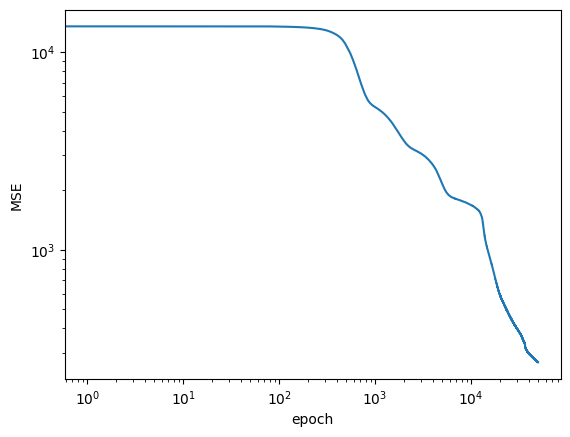

In [10]:
plt.loglog(logs)
plt.xlabel('epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'y')

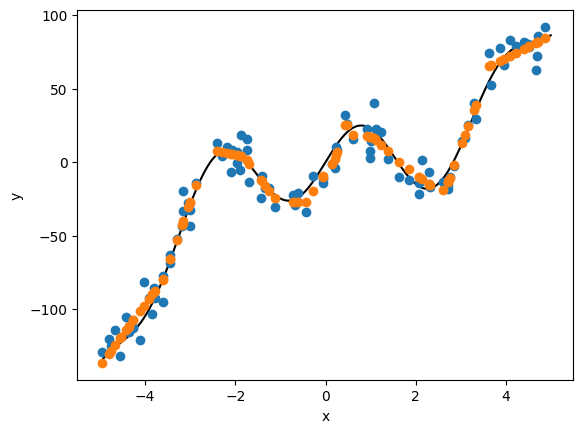

In [11]:
# let's check our predictions
x_ = torch.from_numpy(x.astype('float32'))
ypred = model(torch.reshape(x_, (len(x_), 1))).squeeze().cpu().detach().numpy()

plt.plot(xtrue, ytrue, color='k')
plt.plot(x, y, 'o', color='C0')
plt.plot(x, ypred, 'o', color='C1')
plt.xlabel('x')
plt.ylabel('y')

**Exercise** Explore the model's behavior

1. Make sure you understand the various lines of code.
2. Change the model layout, activations, optimizer, etc.
3. Change the mini-batch configuration. e.g. All data at once

Run the model when you change something and discuss notable differences. Explain what your observations. (If you do not see anything, that could happen. Explain why)

**Exercise** Revisit the XOR problem with pytorch.

In [2]:
# create data
X = torch.Tensor([[0., 0.],
                  [0., 1.],
                  [1., 0.],
                  [1., 1.]])

y = torch.Tensor([0., 1., 1., 0.]).reshape(X.shape[0], 1)

In [7]:
class XOR(nn.Module):
    def __init__(self):
        super(XOR, self).__init__()
        self.linear = nn.Linear(2, 2)
        self.activation = nn.Sigmoid()
        self.linear2 = nn.Linear(2, 1)
    def forward(self, input):
        x = self.linear(input)
        sig = self.activation(x)
        yh = self.linear2(sig)
        return yh


xor_network = XOR()
epochs = 1000
mseloss = nn.MSELoss()
optimizer = torch.optim.AdamW(xor_network.parameters(), lr = 0.03)
logs = []
for epoch in range(epochs):
    yhat = xor_network.forward(X)
    loss = mseloss(yhat, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (epoch + 1) % 250 == 0:
        print(f'Loss after epoch {epoch+1:5d}: {loss:.4g}')
    logs.append(loss.item())

Loss after epoch   250: 0.1574
Loss after epoch   500: 0.0002156
Loss after epoch   750: 6.146e-05
Loss after epoch  1000: 3.953e-05


Text(0, 0.5, 'MSE')

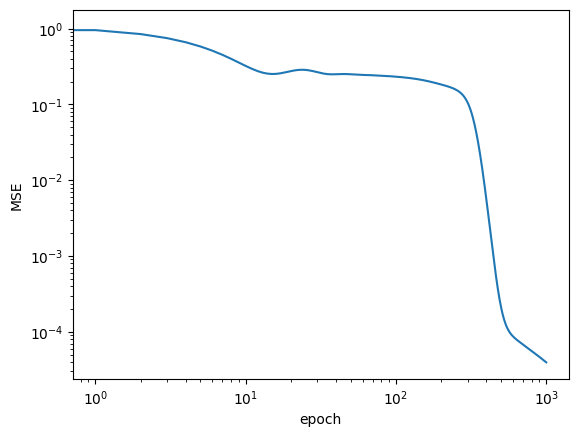

In [8]:
plt.loglog(logs)
plt.xlabel('epoch')
plt.ylabel('MSE')

(-0.04, 1.04)

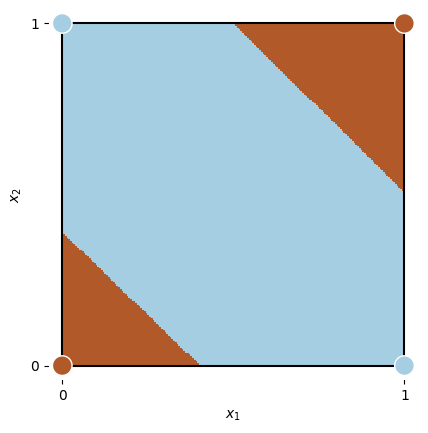

In [11]:
def plot_data(xor_data, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='k')
    ax.scatter(xor_data[:, 0], xor_data[:, 1], c=xor_data[:, 2],
               cmap='Paired_r', s=200, zorder=10, edgecolors='w')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    plt.setp(ax.spines.values(), color='w')
    ax.set_xticks([0, 1], [0, 1])
    ax.set_yticks([0, 1], [0, 1])

X_, Y_ = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
x1 = torch.from_numpy(np.c_[X_.ravel().astype('float32'), Y_.ravel().astype('float32')])
Z = np.round(xor_network(x1).squeeze().cpu().detach().numpy())

xor_data = np.array([[0, 0, 0],
                     [1, 0, 1],
                     [0, 1, 1],
                     [1, 1, 0]])

ax = plt.subplot(111, aspect='equal')
plot_data(xor_data, ax)
Z = Z.reshape(X_.shape)
plt.pcolormesh(X_, Y_, Z, cmap=plt.cm.Paired_r)
plt.xlim(-0.04, 1.04)
plt.ylim(-0.04, 1.04);